<a href="https://colab.research.google.com/github/imaleaf03/bigdata-real_estate-model/blob/main/USA_RE_time.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [56]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Load dataset
file_path = 'realtor-data.zip.csv'
df = pd.read_csv(file_path)

print("Shape of dataset:", df.shape)
df.head()


Shape of dataset: (2226382, 12)


,brokered_by,status,price,bed,bath,acre_lot,street,city,state,zip_code,house_size,prev_sold_date
0,103378.0,for_sale,105000.0,3.0,2.0,0.12,1962661.0,Adjuntas,Puerto Rico,601.0,920.0,NaN
1,52707.0,for_sale,80000.0,4.0,2.0,0.08,1902874.0,Adjuntas,Puerto Rico,601.0,1527.0,NaN
2,103379.0,for_sale,67000.0,2.0,1.0,0.15,1404990.0,Juana Diaz,Puerto Rico,795.0,748.0,NaN
3,31239.0,for_sale,145000.0,4.0,2.0,0.10,1947675.0,Ponce,Puerto Rico,731.0,1800.0,NaN
4,34632.0,for_sale,65000.0,6.0,2.0,0.05,331151.0,Mayaguez,Puerto Rico,680.0,NaN,NaN


brokered by (categorically encoded agency/broker)

status (Housing status - a. ready for sale or b. ready to build)

price (Housing price, it is either the current listing price or recently sold price if the house is sold recently)

bed (# of beds)

bath (# of bathrooms)

acre_lot (Property / Land size in acres)

street (categorically encoded street address)

city (city name)

state (state name)

zip_code (postal code of the area)

house_size (house area/size/living space in square feet)

prev_sold_date (Previously sold date)

In [57]:
#Missing value
missing = df.isnull().sum()
missing = missing[missing > 0]
print(missing)

brokered_by         4533
price               1541
bed               481317
bath              511771
acre_lot          325589
street             10866
city                1407
state                  8
zip_code             299
house_size        568484
prev_sold_date    734297
dtype: int64


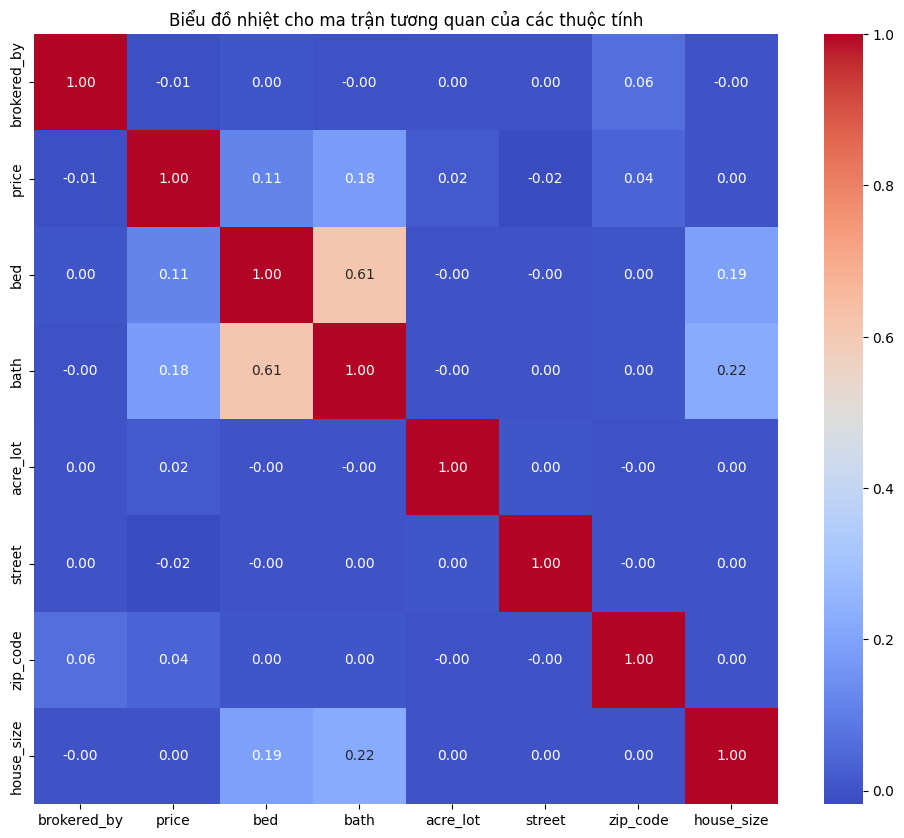

In [58]:
# Select numerical columns for correlation matrix
numerical_cols = df.select_dtypes(include=np.number).columns

# Calculate the correlation matrix
correlation_matrix = df[numerical_cols].corr()

# Display the correlation matrix (optional: using a heatmap for better visualization)
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Biểu đồ nhiệt cho ma trận tương quan của các thuộc tính')
plt.show()

In [59]:
# Convert zip_code and street to string (categorical)
df['zip_code'] = df['zip_code'].astype(str)
df['street'] = df['street'].astype(str)

# Convert prev_sold_date to datetime with errors='coerce' to turn invalid parsing into NaT
df['prev_sold_date'] = pd.to_datetime(df['prev_sold_date'], errors='coerce')

# Drop rows with missing critical data
# Drop rows where prev_sold_date is NaT (resulting from errors='coerce' or original NaN)
df = df.dropna(subset=['price', 'prev_sold_date'])

# Drop rows with invalid zero values for price (and potentially others if needed later)
df = df[df['price'] > 0]


# Convert house_size, acre_lot to numeric (again for safety)
df['house_size'] = pd.to_numeric(df['house_size'], errors='coerce')
df['acre_lot'] = pd.to_numeric(df['acre_lot'], errors='coerce')


# Final check
print("New shape after cleaning:", df.shape)
print(df.isnull().sum())

New shape after cleaning: (1491581, 12)
brokered_by         3612
status                 0
price                  0
bed               155543
bath              161998
acre_lot          194560
street                 0
city                 338
state                  0
zip_code               0
house_size        222810
prev_sold_date         0
dtype: int64


In [60]:
'''# Avoid division by zero
df['price_per_sqft'] = df['price'] / df['house_size']
df['is_luxury_home'] = df['price'].apply(lambda x: 1 if x > 1_000_000 else 0)
'''
df['price_category'] = pd.cut(df['price'], bins=[0, 250000, 500000, 1000000, float('inf')],
                              labels=['Low', 'Medium', 'High', 'Luxury'])


In [61]:
# Convert 'prev_sold_date' to datetime
df['prev_sold_date'] = pd.to_datetime(df['prev_sold_date'], errors='coerce')

# Display the data type of the column and the first few rows to verify
print(df['prev_sold_date'].dtype)
print(df['prev_sold_date'].head())

datetime64[ns]
411    2020-02-28
502    2019-06-28
1025   2021-09-15
1160   2021-03-15
2270   2013-10-11
Name: prev_sold_date, dtype: datetime64[ns]


In [62]:
# Extract year and month from prev_sold_date
# Since rows with missing or invalid prev_sold_date are dropped, we don't expect NaNs here
df['prev_sold_year'] = df['prev_sold_date'].dt.year.astype(int)
df['prev_sold_quarter'] = df['prev_sold_date'].dt.quarter.astype(int)
df['prev_sold_month'] = df['prev_sold_date'].dt.month.astype(int)

# Display the first few rows to see the new columns
display(df)

,brokered_by,status,price,bed,bath,acre_lot,street,city,state,zip_code,house_size,prev_sold_date,price_category,prev_sold_year,prev_sold_quarter,prev_sold_month
411,52270.0,for_sale,76900.0,3.0,2.0,NaN,1873083.0,Canovanas,Puerto Rico,729.0,1200.0,2020-02-28,Low,2020,1,2
502,92147.0,for_sale,110000.0,7.0,3.0,0.09,1842706.0,Dorado,Puerto Rico,949.0,1192.0,2019-06-28,Low,2019,2,6
1025,52707.0,for_sale,159000.0,3.0,2.0,NaN,1657337.0,Caguas,Puerto Rico,725.0,1625.0,2021-09-15,Low,2021,3,9
1160,66902.0,for_sale,380000.0,NaN,NaN,78.66,1902753.0,Yabucoa,Puerto Rico,767.0,NaN,2021-03-15,Medium,2021,1,3
2270,94933.0,for_sale,950000.0,5.0,4.0,0.99,1260473.0,Saint Thomas,Virgin Islands,802.0,5000.0,2013-10-11,High,2013,4,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2226377,23009.0,sold,359900.0,4.0,2.0,0.33,353094.0,Richland,Washington,99354.0,3600.0,2022-03-25,Medium,2022,1,3
2226378,18208.0,sold,350000.0,3.0,2.0,0.10,1062149.0,Richland,Washington,99354.0,1616.0,2022-03-25,Medium,2022,1,3
2226379,76856.0,sold,440000.0,6.0,3.0,0.50,405677.0,Richland,Washington,99354.0,3200.0,2022-03-24,Medium,2022,1,3
2226380,53618.0,sold,179900.0,2.0,1.0,0.09,761379.0,Richland,Washington,99354.0,933.0,2022-03-24,Low,2022,1,3


In [63]:
# Count the number of properties sold in each year
sales_by_year = df['prev_sold_year'].value_counts().sort_values(ascending=False)
# Display the counts
print("Number of properties sold per year")
sales_by_year.head(20)

Number of properties sold per year


,count
prev_sold_year,
2022,613563
2021,316470
2019,47955
2018,44227
2020,43887
2017,38355
2016,33667
2015,28736
2005,25135


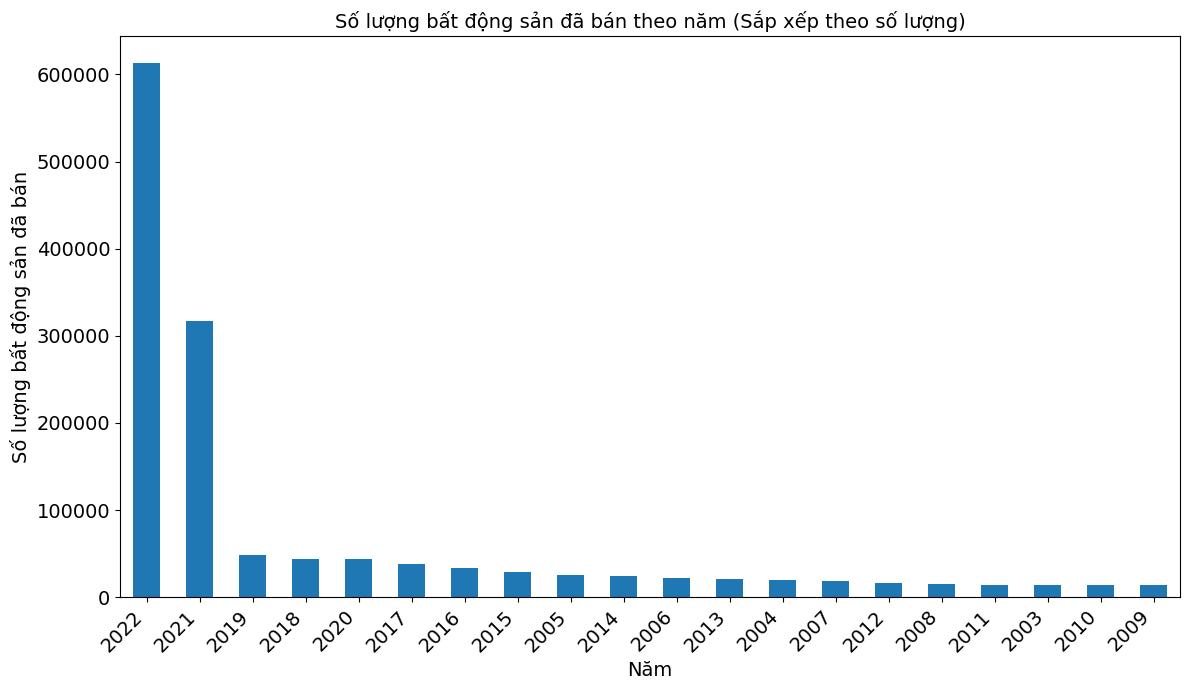

In [64]:
# Visualize the sales by year
plt.figure(figsize=(12, 7))
ax = sales_by_year.head(20).plot(kind='bar')
plt.title('Số lượng bất động sản đã bán theo năm (Sắp xếp theo số lượng)', fontsize=14)
plt.xlabel('Năm', fontsize=14)
plt.ylabel('Số lượng bất động sản đã bán', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=14) # Rotate labels for better readability and adjust font size
plt.yticks(fontsize=14) # Adjust font size for y-axis labels

# Add the counts on top of the bars
#for container in ax.containers:
 #   ax.bar_label(container, fmt='{:,.0f}', fontsize=14)


plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.show()

In [65]:
df['prev_sold_year'].value_counts().sort_values(ascending=True).head(10)

,count
prev_sold_year,
1926,1
2026,1
1951,1
1939,1
1904,1
1949,1
1905,1
1906,1
1941,1


In [66]:
df['prev_sold_decade'] = (df['prev_sold_year'] // 10) * 10

# Count the number of properties sold in each decade
sales_by_decade = df['prev_sold_decade'].value_counts().sort_index()

# Display the counts
print("Number of properties sold per decade:")
print(sales_by_decade)

Number of properties sold per decade:
prev_sold_decade
1900         6
1910         1
1920         2
1930         2
1940         2
1950        52
1960       597
1970      4949
1980     17619
1990     53603
2000    157884
2010    282368
2020    974496
Name: count, dtype: int64


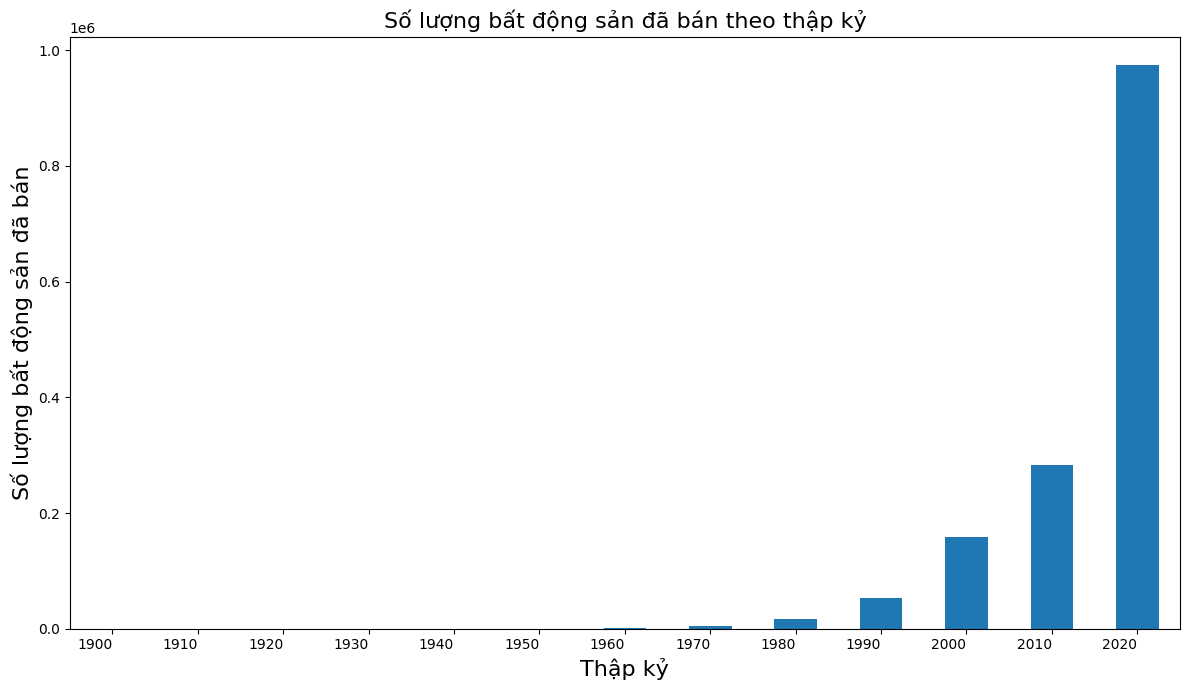

In [67]:
# Visualize the sales by decade
plt.figure(figsize=(12, 7))
ax = sales_by_decade.plot(kind='bar')
plt.title('Số lượng bất động sản đã bán theo thập kỷ', fontsize=16)
plt.xlabel('Thập kỷ', fontsize=16)
plt.ylabel('Số lượng bất động sản đã bán', fontsize=16)
plt.xticks(rotation=0, ha='right') # Rotate labels for better readability

# Add the counts on top of the bars
#for container in ax.containers:
 #   ax.bar_label(container, fmt='{:.0f}')

plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.show()

In [68]:
# Count the number of properties sold in each month
sales_by_month = df['prev_sold_month'].value_counts().sort_index()

# Display the counts
print("Number of properties sold per month:")
print(sales_by_month)

# Count the number of properties sold in each quarter
sales_by_quarter = df['prev_sold_quarter'].value_counts().sort_index()

# Display the counts
print("\nNumber of properties sold per quarter:")
print(sales_by_quarter)

Number of properties sold per month:
prev_sold_month
1     141485
2     153519
3     223901
4     252551
5      72533
6      63673
7      60434
8      59523
9      53920
10     70872
11    156900
12    182270
Name: count, dtype: int64

Number of properties sold per quarter:
prev_sold_quarter
1    518905
2    388757
3    173877
4    410042
Name: count, dtype: int64


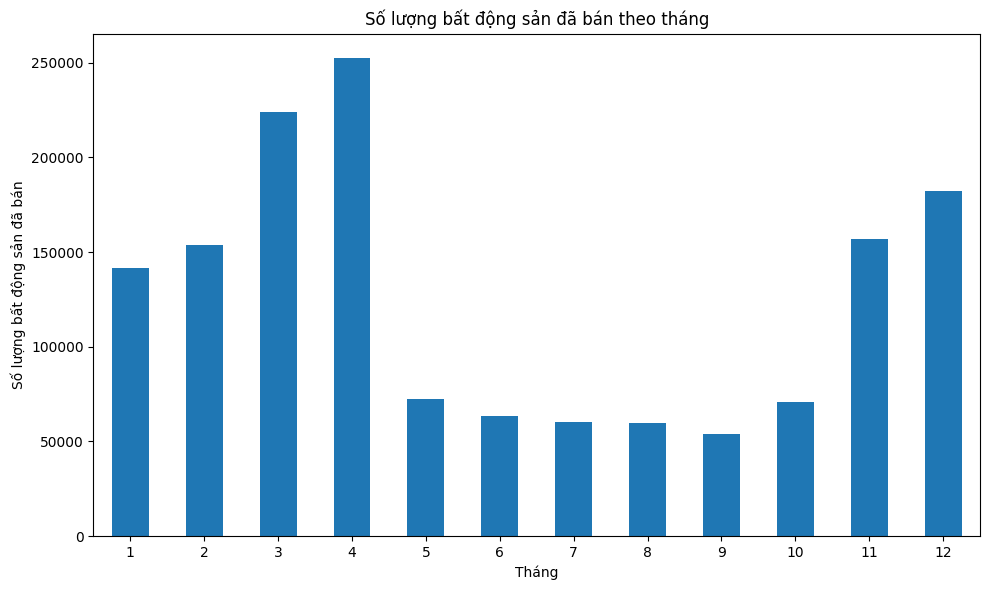

In [69]:
# Visualize the sales by month
plt.figure(figsize=(10, 6))
sales_by_month.plot(kind='bar')
plt.title('Số lượng bất động sản đã bán theo tháng')
plt.xlabel('Tháng')
plt.ylabel('Số lượng bất động sản đã bán')
plt.xticks(rotation=0) # Months are few, no need to rotate much
plt.tight_layout()
plt.show()


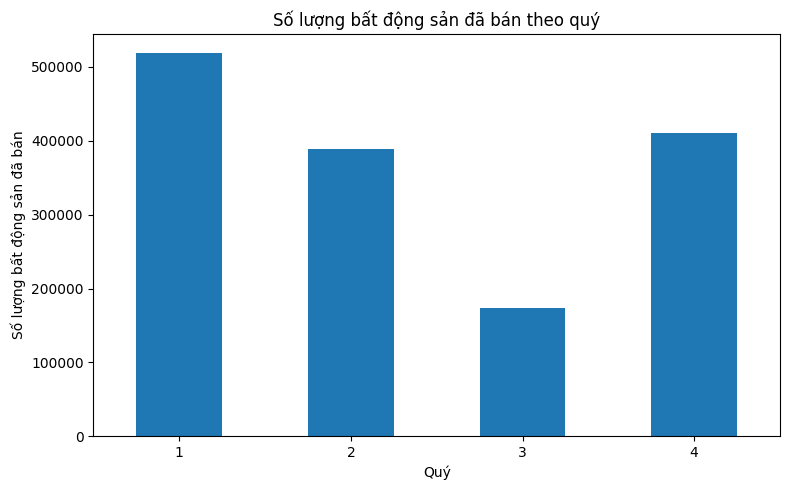

In [70]:
# Visualize the sales by quarter
plt.figure(figsize=(8, 5))
sales_by_quarter.plot(kind='bar')
plt.title('Số lượng bất động sản đã bán theo quý')
plt.xlabel('Quý')
plt.ylabel('Số lượng bất động sản đã bán')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [71]:
# Calculate the average price per year
average_price_by_year = df.groupby('prev_sold_year')['price'].mean()

# Print the average price per year
print("Average property price per year:")
average_price_by_year.sort_values(ascending=False).head(15)

Average property price per year:


,price
prev_sold_year,
1928,6.885000e+06
1957,1.078308e+06
1967,1.040233e+06
1968,9.739546e+05
1972,9.516166e+05
1976,9.017814e+05
1965,8.871584e+05
1974,8.441673e+05
1975,8.389325e+05


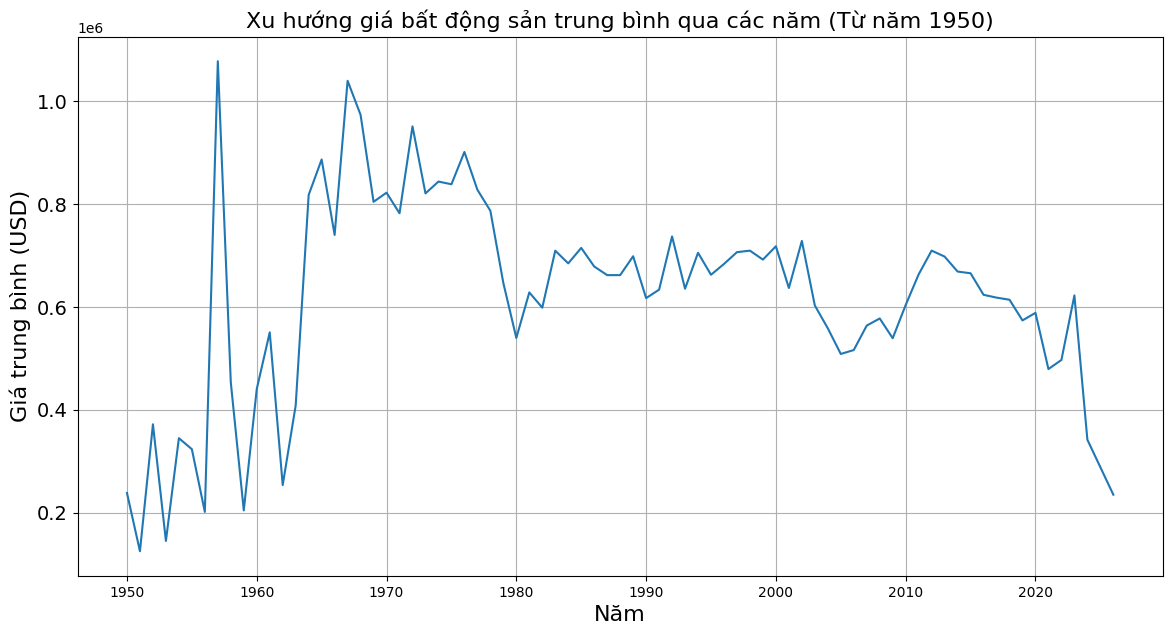

In [72]:
average_price_from_1950 = average_price_by_year[average_price_by_year.index >= 1950]

# Visualize the average price trend over years from 1950
plt.figure(figsize=(14, 7))
average_price_from_1950.plot(kind='line')
plt.title('Xu hướng giá bất động sản trung bình qua các năm (Từ năm 1950)', fontsize=16)
plt.xlabel('Năm', fontsize=16)
plt.ylabel('Giá trung bình (USD)', fontsize=16)
plt.yticks(fontsize=14)
plt.grid(True) # Add a grid for better readability
plt.show()

In [73]:
# Count the number of properties per state
state_counts = df['state'].value_counts()

# Display the top cities by count
print("Top 10 cities by number of properties:")
print(state_counts.head(10))

Top 10 cities by number of properties:
state
Florida         193410
California      193017
Texas           123941
New York         68055
Illinois         63743
Georgia          58251
Arizona          57600
Pennsylvania     54404
Washington       50630
Virginia         49756
Name: count, dtype: int64


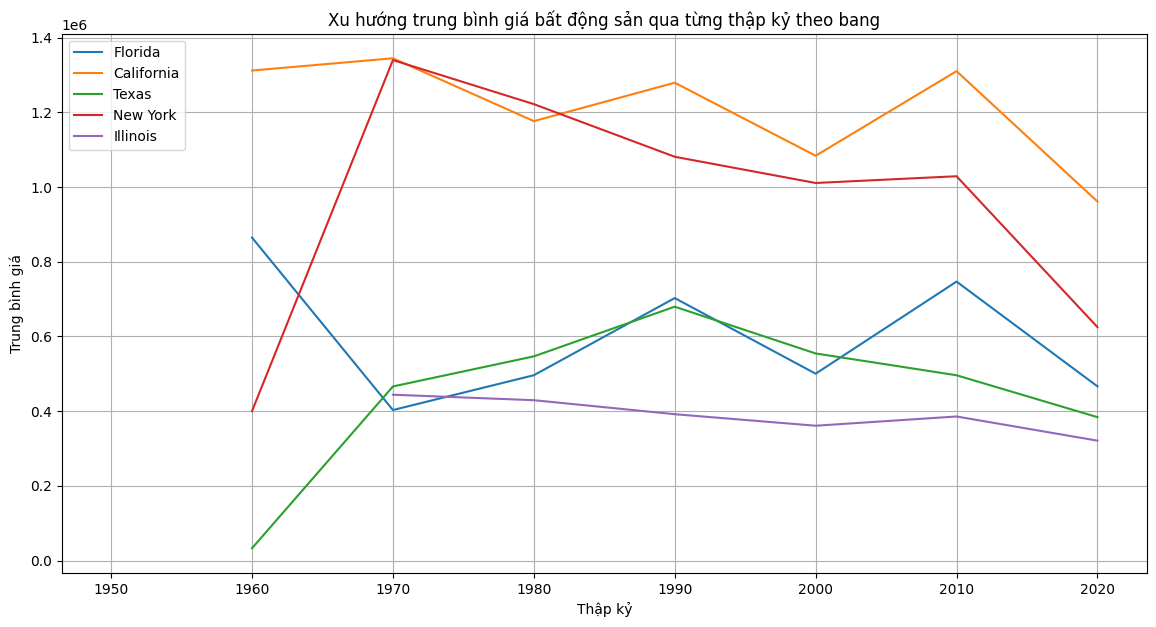

In [75]:
# Calculate average price by state and decade
average_price_by_state_decade = df.groupby(['state', 'prev_sold_decade'])['price'].mean().unstack()

# Filter data from 1950 onwards
average_price_by_state_decade_filtered = average_price_by_state_decade.loc[:, average_price_by_state_decade.columns >= 1950]
top_states = state_counts.head(5).index

average_price_by_state_decade_top = average_price_by_state_decade_filtered.loc[top_states]

# Plot average price by state over decades
plt.figure(figsize=(14, 7))
for state in top_states:
    plt.plot(average_price_by_state_decade_top.columns, average_price_by_state_decade_top.loc[state], label=state)

plt.title('Xu hướng trung bình giá bất động sản qua từng thập kỷ theo bang')
plt.xlabel('Thập kỷ')
plt.ylabel('Trung bình giá')
plt.legend()
plt.grid(True)
plt.show()

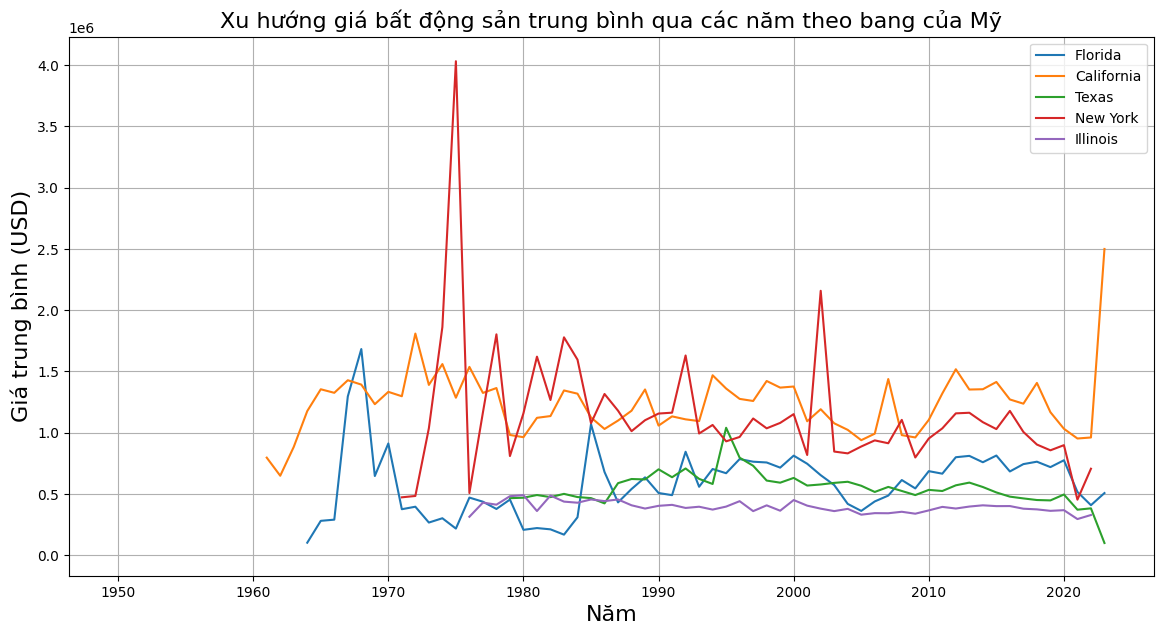

In [22]:
# Calculate average price by state and year
average_price_by_state_year = df.groupby(['state', 'prev_sold_year'])['price'].mean().unstack()

# Filter data from 1950 onwards
average_price_by_state_year_filtered = average_price_by_state_year.loc[:, average_price_by_state_year.columns >= 1950]
top_states = state_counts.head(5).index
average_price_by_state_year_top = average_price_by_state_year_filtered.loc[top_states]

# Plot average price by state over years
plt.figure(figsize=(14, 7))
for state in top_states:
    plt.plot(average_price_by_state_year_top.columns, average_price_by_state_year_top.loc[state], label=state)

plt.title('Xu hướng giá bất động sản trung bình qua các năm theo bang của Mỹ', fontsize=16)
plt.xlabel('Năm', fontsize=16)
plt.ylabel('Giá trung bình (USD)', fontsize=16)
plt.legend()
plt.grid(True)
plt.show()

In [23]:
# Count the number of properties per city
city_counts = df['city'].value_counts()

# Display the top cities by count
print("Top 10 cities by number of properties:")
print(city_counts.head(10))

Top 10 cities by number of properties:
city
Houston          18373
Chicago          14442
Jacksonville      9303
Tucson            8286
New York City     8045
Los Angeles       7913
Phoenix           7682
Philadelphia      7608
Dallas            7411
Miami             7367
Name: count, dtype: int64


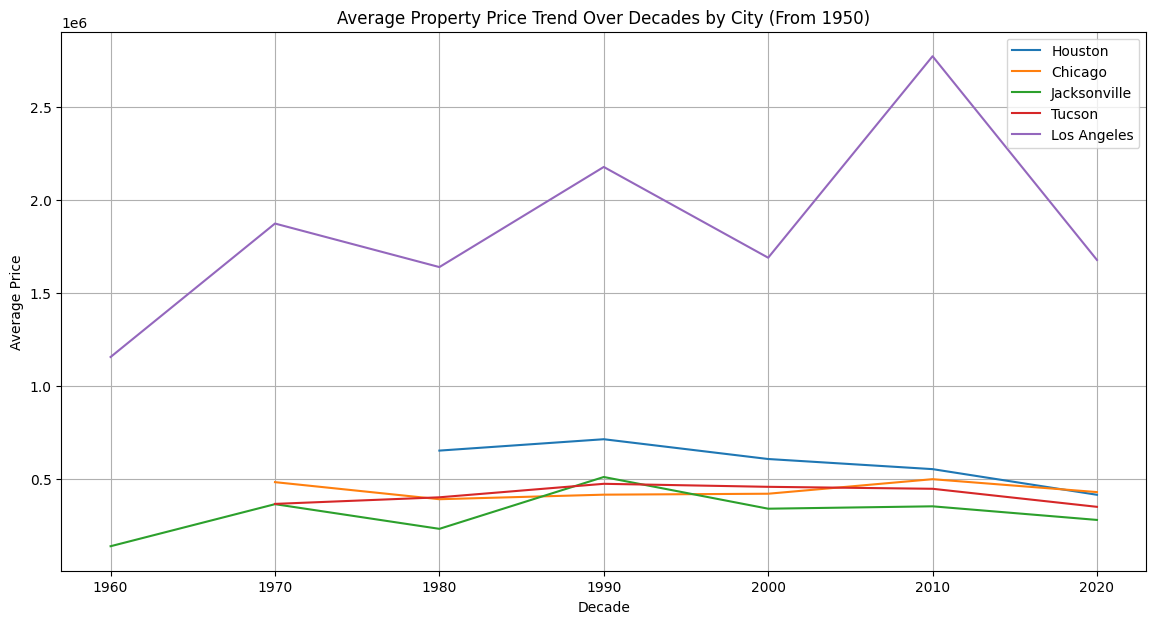

In [24]:
# Calculate average price by city and decade
average_price_by_city_decade = df.groupby(['city', 'prev_sold_decade'])['price'].mean().unstack()

# Filter data from 1950 onwards
average_price_by_city_decade_filtered = average_price_by_city_decade.loc[:, average_price_by_city_decade.columns >= 1950]
#top_cities = city_counts.head(5).index
top_cities = ['Houston', 'Chicago', 'Jacksonville', 'Tucson', 'Los Angeles']
average_price_by_city_decade_top = average_price_by_city_decade_filtered.loc[top_cities]

# Plot average price by city over decades
plt.figure(figsize=(14, 7))
for city in top_cities:
    plt.plot(average_price_by_city_decade_top.columns, average_price_by_city_decade_top.loc[city], label=city)
plt.title('Average Property Price Trend Over Decades by City (From 1950)')
plt.xlabel('Decade')
plt.ylabel('Average Price')
plt.legend()
plt.grid(True)
plt.show()


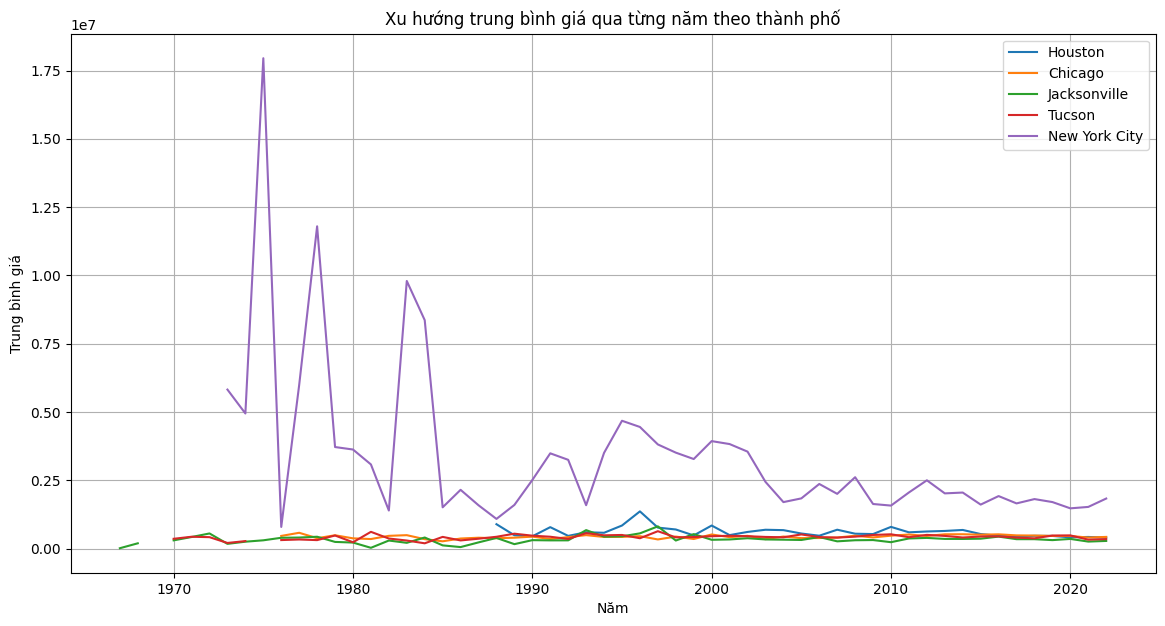

In [76]:
# Calculate average price by city and year
average_price_by_city_year = df.groupby(['city', 'prev_sold_year'])['price'].mean().unstack()

# Filter data from 1950 onwards
average_price_by_city_year_filtered = average_price_by_city_year.loc[:, average_price_by_city_year.columns >= 1950]
top_cities = city_counts.head(5).index
average_price_by_city_year_top = average_price_by_city_year_filtered.loc[top_cities]

# Plot average price by city over years
plt.figure(figsize=(14, 7))
for city in top_cities:
    plt.plot(average_price_by_city_year_top.columns, average_price_by_city_year_top.loc[city], label=city)
plt.title('Xu hướng trung bình giá qua từng năm theo thành phố')
plt.xlabel('Năm')
plt.ylabel('Trung bình giá')
plt.legend()
plt.grid(True)
plt.show()


In [77]:
# Calculate the average price per city
average_price_by_city = df.groupby('city')['price'].mean()

# Sort cities by average price in descending order
cities_by_average_price = average_price_by_city.sort_values(ascending=False)

# Display the top 10 cities by average price
print("Top 10 cities by average property price:")
print(cities_by_average_price.head(10))

Top 10 cities by average property price:
city
Kosse           4.290799e+07
Turbeville      2.250000e+07
Carpinteria     2.184741e+07
Jolly           1.792038e+07
Golden Oak      1.638500e+07
Ashwood         1.555000e+07
Montecito       1.472619e+07
Golden Beach    1.355179e+07
Waccabuc        1.290000e+07
Sagaponack      1.231853e+07
Name: price, dtype: float64
